# CS166 Second Project—Bacteria Growth Simulation

#### Importing all necessary libs

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as sts
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm
from typing import List, Tuple, Optional
import time
from scipy import ndimage
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score



matplotlib.rcParams['animation.embed_limit'] = 2**128

### Animations and Images

**make_animation():** generates an animated visualization of a bacteria simulation over a specified number of frames. It accepts parameters such as the simulation instance, the total number of frames, the number of simulation steps per frame, the time interval between frames, and the starting simulation step. The function initializes a figure with three subplots: one for food distribution, one for bacteria distribution, and one for a combined view. It updates the simulation step-by-step and dynamically updates the images for each plot. A progress bar tracks the animation progress, and the final animation is converted to an HTML5 video format for display in a notebook.

**Visualizer class:** responsible for displaying and updating the visual representation of a bacteria simulation at each timestep. It initializes plots for food distribution, bacteria distribution, and a combined view. The update method redraws the plots and updates the colorbars, dynamically adjusting for changes in the bacteria population. If the plots are already initialized, the update_data_only method ensures that only the data is refreshed without recreating the plots or colorbars. The save_snapshot method allows for saving the current visualization as a PNG file, preserving the state of the simulation at any given point

In [2]:
def make_animation(sim, total_frames, steps_per_frame=1, interval=100, start_from_step=0):
    """
    Creates an animation of the bacteria simulation.

    Args:
        sim: The BacteriaSimulation instance
        total_frames: Number of frames in the animation
        steps_per_frame: Simulation steps per animation frame
        interval: Time between frames in milliseconds
        start_from_step: Reset simulation to this step before starting animation

    Returns:
        HTML: Animation that can be displayed in a notebook
    """
    # reset simulation to starting state
    sim.reset(start_from_step)

    # create a new figure and axes specifically for the animation
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # create progress bar OUTSIDE of the update function
    progress_bar = tqdm(total=total_frames)

    # set up initial images
    food_array = sim.grid.food
    bacteria_array = sim.grid.bacteria

    # set up color maps and normalization
    food_cmap = plt.cm.YlOrRd
    bacteria_cmap = plt.cm.Blues
    food_norm = plt.Normalize(0, sim.params.food_capacity)
    bacteria_norm = plt.Normalize(0, max(1, bacteria_array.max()))

    # initialize the plots
    food_img = axes[0].imshow(food_array, cmap=food_cmap, norm=food_norm)
    axes[0].set_title('Food Distribution')
    plt.colorbar(food_img, ax=axes[0], label='Food Units')

    bacteria_img = axes[1].imshow(bacteria_array, cmap=bacteria_cmap, norm=bacteria_norm)
    axes[1].set_title('Bacteria Distribution')
    plt.colorbar(bacteria_img, ax=axes[1], label='Bacteria Population')

    # combined view
    combined_array = np.zeros((*food_array.shape, 3))
    combined_array[:, :, 0] = food_norm(food_array)
    combined_array[:, :, 2] = bacteria_norm(bacteria_array)
    combined_img = axes[2].imshow(combined_array)
    axes[2].set_title('Combined View')

    fig.suptitle(f'Simulation State at Time Step {sim.timestep}')

    def init():
        return food_img, bacteria_img, combined_img

    def update(frame_number):
        # simulation steps
        for _ in range(steps_per_frame):
            sim.step()

        # updated data
        food_array = sim.grid.food
        bacteria_array = sim.grid.bacteria

        # update bacteria normalization
        max_bacteria = bacteria_array.max()
        if max_bacteria > bacteria_norm.vmax:
            bacteria_norm.vmax = max_bacteria

        # update image data
        food_img.set_data(food_array)
        bacteria_img.set_data(bacteria_array)

        # update combined view
        combined_array = np.zeros((*food_array.shape, 3))
        combined_array[:, :, 0] = food_norm(food_array)
        combined_array[:, :, 2] = bacteria_norm(bacteria_array)
        combined_img.set_data(combined_array)

        fig.suptitle(f'Simulation State at Time Step {sim.timestep}')

        progress_bar.update(1)

        return food_img, bacteria_img, combined_img


    animation = FuncAnimation(
        fig, update, init_func=init,
        frames=total_frames, interval=interval, blit=True)

    # convert to HTML5 video
    output = HTML(animation.to_jshtml())

    # clean up
    progress_bar.close()

    return output

In [3]:
class Visualizer:
    """
    Handles the visualization of a bacteria simulation, including dynamic updates 
    of food and bacteria distributions, as well as their combined view across simulation steps.

    Attributes:
        simulation (BacteriaSimulation): The instance of the bacteria simulation to visualize.
        fig (matplotlib.figure.Figure): The figure object containing the plots.
        axes (list): The list of axes for displaying the food, bacteria, and combined views.
        food_img, bacteria_img, combined_img: Image objects for displaying the food, bacteria, and combined data.
        initialized (bool): Flag indicating whether the plots have been initialized.
        food_colorbar, bacteria_colorbar: Colorbar objects for the food and bacteria plots.
        food_cmap, bacteria_cmap: Color maps for visualizing food and bacteria data.
        food_norm, bacteria_norm: Normalization objects for color mapping food and bacteria values.
        
    Methods:
        update(timestep): Updates the visualization for a specific timestep, creating or updating plots.
        update_data_only(timestep): Updates the displayed data without recreating the plots or colorbars.
        save_snapshot(filename=None): Saves the current state of the visualization to a file.
    """
    def __init__(self, simulation: 'BacteriaSimulation'):
        self.simulation = simulation
        plt.ion()  # interactive mode
        self.fig, self.axes = plt.subplots(1, 3, figsize=(15, 5))
        self.food_img = None
        self.bacteria_img = None
        self.combined_img = None
        self.initialized = False
        self.food_colorbar = None
        self.bacteria_colorbar = None

        # color maps and normalization
        self.food_cmap = plt.cm.YlOrRd
        self.bacteria_cmap = plt.cm.Blues
        self.food_norm = plt.Normalize(0, simulation.params.food_capacity)
        self.bacteria_norm = plt.Normalize(0, 1)  # Will be updated dynamically

    def update(self, timestep: int):
        """Full update including creation of plots and colorbars."""
        food_array = self.simulation.grid.food
        bacteria_array = self.simulation.grid.bacteria

        # bacteria normalization
        if bacteria_array.max() > 0:
            self.bacteria_norm = plt.Normalize(0, bacteria_array.max())

        # initialization of plots
        if not self.initialized:
            # clear previous content
            for ax in self.axes:
                ax.clear()

            # food plot
            self.food_img = self.axes[0].imshow(food_array, cmap=self.food_cmap,
                                               norm=self.food_norm)
            self.axes[0].set_title('Food Distribution')
            self.food_colorbar = plt.colorbar(self.food_img, ax=self.axes[0], label='Food Units')

            # bacteria plot
            self.bacteria_img = self.axes[1].imshow(bacteria_array, cmap=self.bacteria_cmap,
                                                  norm=self.bacteria_norm)
            self.axes[1].set_title('Bacteria Distribution')
            self.bacteria_colorbar = plt.colorbar(self.bacteria_img, ax=self.axes[1], label='Bacteria Population')

            # combined plot
            combined_array = np.zeros((*food_array.shape, 3))
            combined_array[:, :, 0] = self.food_norm(food_array) 
            combined_array[:, :, 2] = self.bacteria_norm(bacteria_array)

            self.combined_img = self.axes[2].imshow(combined_array)
            self.axes[2].set_title('Combined View')

            self.initialized = True
        else:
            self.update_data_only(timestep)

        # update title and force redraw
        self.fig.suptitle(f'Simulation State at Time Step {timestep}')
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()  # make sure the GUI events are processed
        plt.pause(0.01) 

    def update_data_only(self, timestep: int):
        """Updates only the data without recreating plots or colorbars."""
        food_array = self.simulation.grid.food
        bacteria_array = self.simulation.grid.bacteria

        # bacteria normalization
        max_bacteria = bacteria_array.max()
        if max_bacteria > 0 and max_bacteria > self.bacteria_norm.vmax:
            self.bacteria_norm = plt.Normalize(0, max_bacteria)
            self.bacteria_img.set_norm(self.bacteria_norm)

            # update colorbar (had some issues with repetition and added this)
            if hasattr(self, 'bacteria_colorbar') and self.bacteria_colorbar is not None:
                self.bacteria_colorbar.update_bruteforce(self.bacteria_img)

        # update existing images
        self.food_img.set_data(food_array)
        self.bacteria_img.set_data(bacteria_array)

        # update combined view
        combined_array = np.zeros((*food_array.shape, 3))
        combined_array[:, :, 0] = self.food_norm(food_array)  # Red channel for food
        combined_array[:, :, 2] = self.bacteria_norm(bacteria_array)  # Blue channel for bacteria
        self.combined_img.set_data(combined_array)

        self.fig.suptitle(f'Simulation State at Time Step {timestep}')

    def save_snapshot(self, filename=None):
        """Saves the current visualization state to a file."""
        if filename is None:
            filename = f"simulation_step_{self.simulation.timestep}.png"
        self.fig.savefig(filename, dpi=150, bbox_inches='tight')
        print(f"Saved snapshot to {filename}")

### Cell Class

In [4]:
class Cell:
    """
    Represents a single cell in the simulation grid, storing values for food and bacteria.
    
    Attributes:
        food (float): The amount of food present in the cell.
        bacteria (float): The amount of bacteria present in the cell.

    Methods:
        __repr__(): Returns a string representation of the cell's current state, showing
                    the amount of food and bacteria with two decimal precision.
    """
    def __init__(self, food: float = 0.0, bacteria: float = 0.0):
        self.food = food
        self.bacteria = bacteria

    def __repr__(self):
        return f"Cell(food={self.food:.2f}, bacteria={self.bacteria:.2f})"

### Grid Class

In [5]:
class Grid:
    """
    Represents a 2D grid of cells, with attributes for food and bacteria distributions.

    Attributes:
        width (int): The number of columns in the grid.
        height (int): The number of rows in the grid.
        food (numpy.ndarray): A 2D array representing the food distribution across the grid.
        bacteria (numpy.ndarray): A 2D array representing the bacteria population across the grid.

    Methods:
        update_attribute(attr_name, values): Updates the specified attribute (food or bacteria) 
                                              with new values.
    """
    def __init__(self, width: int, height: int):
        self.width = width
        self.height = height
        self.food = np.zeros((height, width))
        self.bacteria = np.zeros((height, width))

    def update_attribute(self, attr_name, values):
        """Update an entire attribute array at once"""
        if hasattr(self, attr_name):
            setattr(self, attr_name, values)

### Bacteria Simulation

#### Parameters

In [6]:
class SimulationParameters:
    """Stores all simulation parameters."""
    def __init__(self,
                 food_capacity=100.0,
                 food_growth_rate=0.6,
                 food_diffusion_rate=0.4,
                 food_reseed_p=0.01,
                 bacteria_consumption_rate=0.5,
                 bacteria_growth_rate=0.6,
                 bacteria_diffusion_rate=0.4):
        self.food_capacity = food_capacity  # k_f
        self.food_growth_rate = food_growth_rate  # g_f
        self.food_diffusion_rate = food_diffusion_rate  # d_f
        self.food_reseed_p = food_reseed_p
        self.bacteria_consumption_rate = bacteria_consumption_rate  # c_b
        self.bacteria_growth_rate = bacteria_growth_rate  # g_b
        self.bacteria_diffusion_rate = bacteria_diffusion_rate  # d_b

#### Simulation Class

In [7]:
class BacteriaSimulation:
    """Main simulation class that coordinates all processes."""
    
    def __init__(self, width: int, height: int, params: SimulationParameters, auto_initialize=True, verbose_mode=True, zoom=False, equilibrium_analysis=False, place_in_middle=True, nowrap=False):
        """
        Initializes the BacteriaSimulation with the provided grid dimensions, simulation parameters, and other configurations.

        Args:
            width (int): Width of the grid.
            height (int): Height of the grid.
            params (SimulationParameters): Simulation parameters defining various rates and limits.
            auto_initialize (bool): If True, the simulation is initialized automatically.
            verbose_mode (bool): If True, prints initialization details.
            zoom (bool): If True, zooms into a section of the plot.
            equilibrium_analysis (bool): If True, includes analysis of system equilibrium.
            place_in_middle (bool): If True, initializes bacteria at the center of the grid.
            nowrap (bool): If True, grid has no wrap-around behavior.
        """
        self.grid = Grid(width, height)
        self.width = width
        self.height = height
        self.params = params
        self.visualizer = Visualizer(self)
        self.timestep = 0
        self.verbose_mode = verbose_mode
        self.zoom = zoom
        self.equilibrium_analysis = equilibrium_analysis
        self.place_in_middle = place_in_middle
        self.nowrap = nowrap

        # lists to store average values over time
        self.avg_food_per_cell = []
        self.avg_bacteria_per_cell = []

        self.init_food_probability = 0.2
        self.init_bacteria_probability = 0.4
        self.init_max_food = 50
        self.init_max_bacteria = 5

        if auto_initialize:
            self.initialize()

    def masking(self, probability):
        """
        Note: This method is not strictly necessary given I am not using masking that many times on my code (but enough to bug me a little bit).
        However, I figured: why not? This would be a good (and small) exercise to add a bit more abstraction and modularity to the code.
        Generates a masked 2D array with Boolean values based on a given probability.
        This method creates a mask of shape `(height, width)` where each cell has a probability
        of being `True`, based on the provided `probability`. The mask can be used to decide
        where a certain variable (like food or bacteria) should be placed in the grid.
        Args:
        probability (float): Probability of a cell being assigned a `True` value (spawned). Must be between 0 and 1.
        Returns:
        np.ndarray: A 2D array of Boolean values (`True` or `False`) indicating where the variable should be placed.
        """
        # distributing True/False on a 2D array following a set probability
        mask = np.random.random((self.height, self.width)) < probability
        return mask


    def initial_distribution(self, spawn_probability, max_initial_population):
        """
        Note: Similar to masking() this method is not strictly necessary, but again: why not?

        Generates a 2D array of random values assigned to cells based on a probability mask.

        This method first generates a probability mask using `masking()`, and then assigns random values
        to the cells where the mask is `True`, up to a specified maximum value (`max_initial_population`).

        Args:
          spawn_probability (float): Probability of a cell being assigned a nonzero value (spawned).
          max_initial_population (float): Maximum possible value assigned to a cell if it is spawned (e.g., maximum food or bacteria).

        Returns:
          np.ndarray: A 2D array where values are assigned according to the probability mask and random distribution.
        """
        mask = self.masking(spawn_probability)
        random_amounts = np.random.random((self.height, self.width)) * max_initial_population # 2D array with random food/bacteria quantities
        initial_distribution = mask * random_amounts # True * value → value (preserves the value where food/bacteria should be placed) or 0 if False
        return initial_distribution

    def initialize(self, food_probability=0.3, bacteria_probability=0.3,
              max_food=50, max_bacteria=5):
        """
        Initializes the simulation with configurable parameters and places food and bacteria on the grid.

        Args:
            food_probability (float): Probability of food being placed in each cell.
            bacteria_probability (float): Probability of bacteria being placed in each cell.
            max_food (int): Maximum amount of food a cell can hold.
            max_bacteria (int): Maximum number of bacteria a cell can have.
        """

        self.init_food_probability = food_probability
        self.init_bacteria_probability = bacteria_probability
        self.init_max_food = max_food
        self.init_max_bacteria = max_bacteria

        if self.verbose_mode:
            print(f"Initializing with: food_probability={food_probability}, "
            f"bacteria_probability={bacteria_probability}, "
            f"max_food={max_food}, max_bacteria={max_bacteria}")

        # Reset grids to empty first
        self.grid.food = np.zeros((self.height, self.width))
        self.grid.bacteria = np.zeros((self.height, self.width))

        if self.place_in_middle:
            # Place bacteria only in the middle cell
            x_mid, y_mid = self.width // 2, self.height // 2
            self.grid.bacteria[y_mid, x_mid] = 30  # Add 30 bacteria in the middle

            # Generate food using masking approach
            mask = self.masking(food_probability)
            # Random food amounts between 20 and max_food where mask is True
            food_values = np.random.randint(20, max_food + 1, size=(self.height, self.width))
            self.grid.food = mask * food_values
        else:
            # Use the masking approach for both bacteria and food
            bacteria_mask = self.masking(bacteria_probability)
            food_mask = self.masking(food_probability)

            # Generate random values between bounds
            bacteria_values = np.random.randint(1, max_bacteria + 1, size=(self.height, self.width))
            food_values = np.random.randint(20, max_food + 1, size=(self.height, self.width))

            # Apply masks
            self.grid.bacteria = bacteria_mask * bacteria_values
            self.grid.food = food_mask * food_values


    def step(self, visualize=True):
        """
        Executes one complete simulation step, updating the grid's food and bacteria populations.

        Args:
            visualize (bool): If True, updates the visualization after the step.
        """
        self.grow_food()
        self.reseed_food()
        self.diffuse_food()
        self.handle_consumption()
        self.handle_reproduction()
        self.diffuse_bacteria()

        self.avg_food_per_cell.append(np.mean(self.grid.food))
        self.avg_bacteria_per_cell.append(np.mean(self.grid.bacteria))


        if visualize:
            self.visualizer.update(self.timestep)

        self.timestep += 1

    def grow_food(self):
        """Implements logistic growth for food in each cell."""

        growth_factor = self.grid.food*(1 + self.params.food_growth_rate*(1-(self.grid.food/self.params.food_capacity)))
        self.grid.food = np.minimum(growth_factor, self.params.food_capacity)

    def reseed_food(self):
        """Adds food randomly according to reseed probability."""
        reseed_mask = self.masking(self.params.food_reseed_p)

        # add 1 unit of food to cells in the mask -> ensuring we don't exceed max capacity
        self.grid.food = np.where(reseed_mask, np.minimum(self.grid.food + 1.0,
                        self.params.food_capacity), self.grid.food)


    def diffusion(self, attr_name, diffusion_rate):
        """
        Generic method to handle diffusion of any cell attribute. (This is me trying (again) to make the code a bit more modular.)

        Args:
            attribute_name (str): The cell attribute to diffuse ('food' or 'bacteria')
            diffusion_rate (float): The diffusion rate to use
        """
        
        grid_values = getattr(self.grid, attr_name)

        enduring_amount = grid_values * (1 - diffusion_rate)
        diffusing_amount = grid_values * diffusion_rate / 4
        
        
        if self.nowrap:
            # arrays for diffusion in each direction
            diffuse_up = np.zeros_like(grid_values)
            diffuse_down = np.zeros_like(grid_values)
            diffuse_left = np.zeros_like(grid_values)
            diffuse_right = np.zeros_like(grid_values)

            # for each direction only copy values where there's a neighbor
            diffuse_up[:-1, :] = diffusing_amount[1:, :]
            diffuse_down[1:, :] = diffusing_amount[:-1, :]
            diffuse_left[:, :-1] = diffusing_amount[:, 1:]
            diffuse_right[:, 1:] = diffusing_amount[:, :-1]

            new_grid_values = enduring_amount + diffuse_up + diffuse_down + diffuse_left + diffuse_right

        else:
            new_grid_values = enduring_amount + (
            np.roll(diffusing_amount, shift=1, axis=0) +  # Down
            np.roll(diffusing_amount, shift=-1, axis=0) +  # Up
            np.roll(diffusing_amount, shift=1, axis=1) +  # Right
            np.roll(diffusing_amount, shift=-1, axis=1)  # Left
            )

        self.grid.update_attribute(attr_name, new_grid_values)


    def diffuse_food(self):
        """Handles food diffusion to neighboring cells."""
        self.diffusion('food', self.params.food_diffusion_rate)

    def handle_consumption(self):
        """Manages bacteria consuming food."""

        required_food = self.grid.bacteria * self.params.bacteria_consumption_rate
        available_food = np.minimum(self.grid.food, required_food)
        
        # track the amount of food consumed by each bacteria
        bacteria_fed = np.zeros_like(self.grid.bacteria)
        is_bacteria = self.grid.bacteria > 0
        bacteria_fed[is_bacteria] = available_food[is_bacteria] / self.params.bacteria_consumption_rate
        
        self.grid.food -= available_food
        self.grid.bacteria = bacteria_fed

    def handle_reproduction(self):
        """Manages reproduction of bacteria that ate."""
        new_bacteria = self.grid.bacteria * (1 + self.params.bacteria_growth_rate)
        self.grid.bacteria = new_bacteria

    def diffuse_bacteria(self):
        """Handles bacteria diffusion to neighboring cells."""
        self.diffusion('bacteria', self.params.bacteria_diffusion_rate)

    def reset(self, timestep=0, initialize=True):
        """
        Resets the simulation to its initial state or to a specific timestep, and optionally reinitializes the grid.

        Args:
            timestep (int): The timestep to reset the simulation to.
            initialize (bool): If True, the grid is reinitialized after resetting.
        """
        
        self.grid = Grid(self.width, self.height)
        self.timestep = timestep

        if initialize:
            self.initialize(
                food_probability=self.init_food_probability,
                bacteria_probability=self.init_bacteria_probability,
                max_food=self.init_max_food,
                max_bacteria=self.init_max_bacteria)

        # fast-forward
        for _ in range(timestep):
            self.step(visualize=False)

    def plot_avgs(self):
        """Plots the average food and bacteria per cell over time."""
        plt.figure(figsize=(10, 5))
        plt.plot(self.avg_food_per_cell, label="Avg Food per Cell", color="green")
        plt.plot(self.avg_bacteria_per_cell, label="Avg Bacteria per Cell", color="blue")

        if self.equilibrium_analysis:
            if len(self.avg_bacteria_per_cell) >= 300:
                bacteria_stabilization = np.mean(self.avg_bacteria_per_cell[-300:])
                food_stabilization = np.mean(self.avg_food_per_cell[-300:])

                plt.axhline(y=bacteria_stabilization, color='red',
                      label=f"Bacteria Stabilization (~{bacteria_stabilization:.1f})")
                plt.axhline(y=food_stabilization, color='red', alpha=0.6,
                      label=f"Food Stabilization (~{food_stabilization:.1f})")
        if self.zoom:
            plt.xlim(200, 1000)
        plt.xlabel("Timestep")
        plt.ylabel("Average Population per Cell")
        plt.title("Bacteria & Food Population Over Time")
        plt.legend()
        plt.show()

### Run simulation

Initializing with: food_probability=0.3, bacteria_probability=0.3, max_food=50, max_bacteria=5


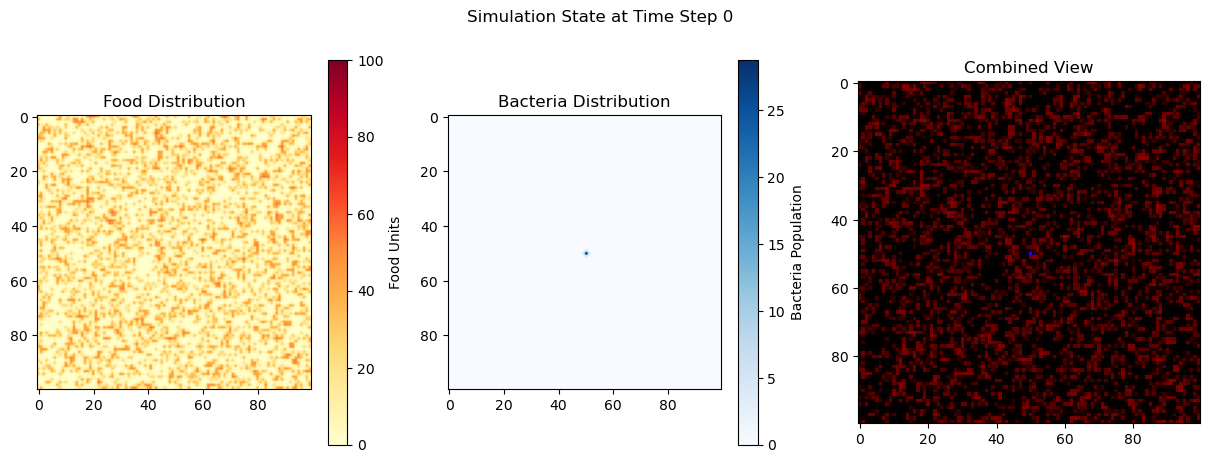

Saved snapshot to simOG_step_0.png
Saved snapshot to simOG_step_1000.png
Saved snapshot to simOG_step_2000.png
Saved snapshot to simOG_step_3000.png
Saved snapshot to simOG_step_4000.png
Saved snapshot to simOG_step_5000.png
Saved snapshot to simOG_step_6000.png
Saved snapshot to simOG_step_7000.png
Saved snapshot to simOG_step_8000.png
Saved snapshot to simOG_step_9000.png


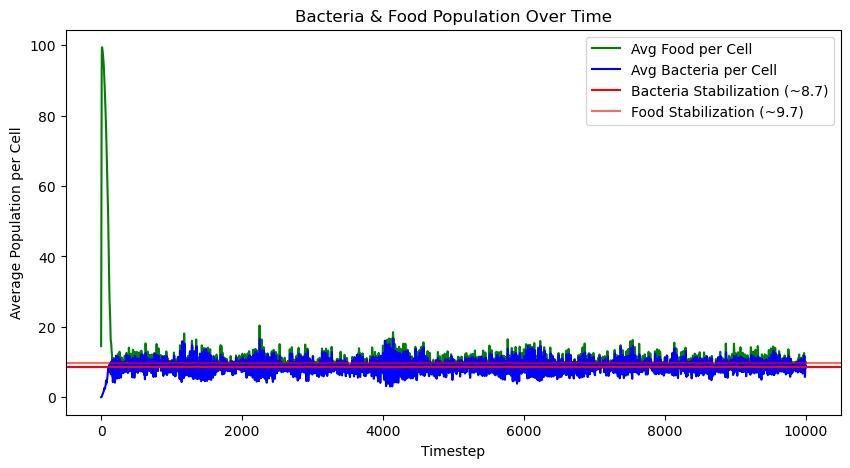

In [8]:
# initialize
params = SimulationParameters()
sim = BacteriaSimulation(width=100, height=100, params=params, equilibrium_analysis=True)

# run simulation
for step in range(10000):
    sim.step()

    # save snapshots at certain intervals
    if step % 1000 == 0:
        sim.visualizer.save_snapshot(f"simOG_step_{step}.png")

    # delay to see the animation
    time.sleep(0.1)

sim.plot_avgs()

### Create animation

Initializing with: food_probability=0.3, bacteria_probability=0.3, max_food=50, max_bacteria=5


  0%|                                                   | 0/200 [00:00<?, ?it/s]

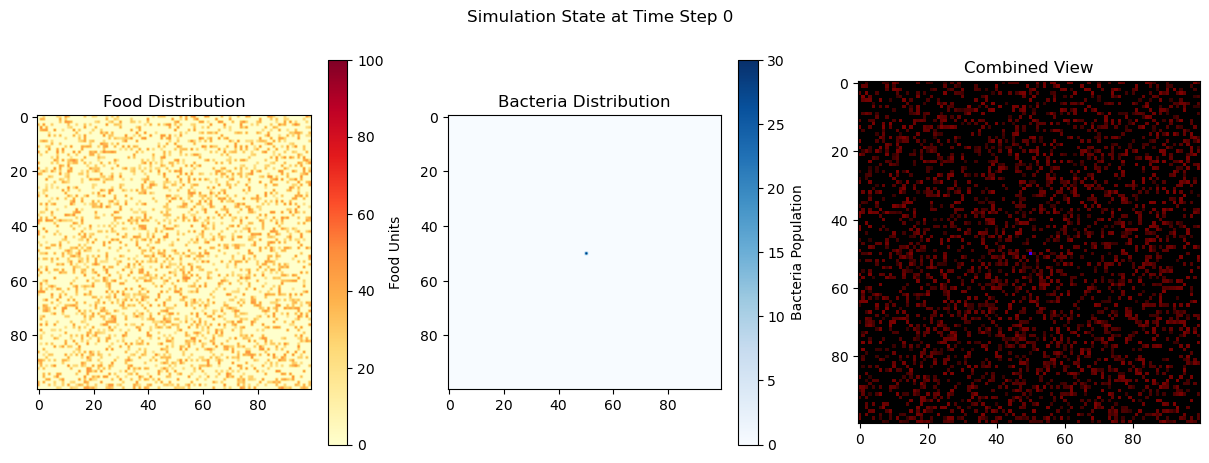

100%|█████████████████████████████████████████| 200/200 [14:40<00:00,  4.40s/it]


In [9]:
animation = make_animation(sim, total_frames=200, steps_per_frame=100, interval=200, start_from_step=0)
display(animation)

## Test Cases

### Test Case 1: No initial food distribution
This test aims to showcase what would happen to the grid if no food was initialized, and we only relied on its growth rate. What we expect to see:
- The initially spawned bacteria will die
- Food, however, will start to grow after some time and the environment will be able to enter an equilibrium eventually

Key parameters to the test:
- food_probability = 0
- bacteria_probability = 0.3

In [10]:
# test with no initial food
test1_params = SimulationParameters(food_reseed_p = 0.0)

sim = BacteriaSimulation(width=100, height=100, params=test1_params, auto_initialize=False, equilibrium_analysis=True)
sim.initialize(food_probability=0.0, bacteria_probability=0.9)

# run simulation
for step in range(1000):
    sim.step()

    # save snapshots at certain intervals
    if step % 100 == 0:
        sim.visualizer.save_snapshot(f"test1_{step}.png")

    # delay to see the animation
    time.sleep(0.1)


sim.plot_avgs()

In [11]:
animation = make_animation(sim, total_frames=100, steps_per_frame=10, interval=200, start_from_step=0)
display(animation)

In [12]:
test12_params = SimulationParameters(food_reseed_p=0.01) # reinforcing

sim = BacteriaSimulation(width=100, height=100, params=test12_params, auto_initialize=False, equilibrium_analysis=True, place_in_middle=False)
sim.initialize(food_probability=0.0, bacteria_probability=0.9)

# run simulation
for step in range(1000):
    sim.step()

    # save snapshots at certain intervals
    if step % 100 == 0:
        sim.visualizer.save_snapshot(f"test12_{step}.png")

    # delay to see the animation
    time.sleep(0.1)


sim.plot_avgs()

In [13]:
animation = make_animation(sim, total_frames=100, steps_per_frame=100, interval=200, start_from_step=0)
display(animation)

### Test Case 2: No bacteria

This test aims to showcase what would happen to the grid if no bacteria was initialized. What we expect to see:

- The food will start being spawned accoridngly to its initialization parameter (food_probability), and will grow following its growth rate
- No bacteria will be spawned at any time step
- The grid will be fully consumed by food at some point, given there is nothing to consume it and slow down its growth

Key parameters to the test:

food_probability = 0.3
bacteria_probability = 0.0

In [14]:
test2_params = SimulationParameters()
sim = BacteriaSimulation(width=100, height=100, params=test2_params, auto_initialize=False, equilibrium_analysis=True)
sim.initialize(bacteria_probability=0.0)

# run simulation
for step in range(1000):
    sim.step()

    # save snapshots at certain intervals
    if step % 100 == 0:
        sim.visualizer.save_snapshot(f"test2_{step}.png")

    # delay to see the animation
    time.sleep(0.1)


sim.plot_avgs()

In [15]:
animation = make_animation(sim, total_frames=100, steps_per_frame=100, interval=200, start_from_step=0)
display(animation)



### Test Case 3: Low consumption rate

This test aims to showcase what would happen to the grid if the bacteria consumption rate was close to zero. What we expect to see:

- The food does not hit the 100 units mark, but stays close to it for long until there is enough baceteria that even the small consumption rate makes an impact
- Bacteria grow at a rapid speed, but little die compared to the total amount

Key parameters to the test:

bacteria_consumption_rate=0.0001

In [16]:
# parameter set with a low bacteria consumption rate
test3 = SimulationParameters(bacteria_consumption_rate=0.0001)
sim = BacteriaSimulation(width=100, height=100, params=test3, equilibrium_analysis=True)

# run simulation
for step in range(1000):
    sim.step()

    # save snapshots at certain intervals
    if step % 100 == 0:
        sim.visualizer.save_snapshot(f"test3_{step}.png")

    # delay to see the animation
    time.sleep(0.1)


sim.plot_avgs()

In [17]:
animation = make_animation(sim, total_frames=100, steps_per_frame=100, interval=200, start_from_step=0)
display(animation)

### Test Case 4: Equal consumption and growth rates

This test aims to showcase what would happen to the grid if the bacteria consumption rate was close to zero. What we expect to see:

- The food does not hit the 100 units mark, but stays close to it for long until there is enough baceteria that even the small consumption rate makes an impact
- Bacteria grow at a rapid speed, but little die compared to the total amount

Key parameters to the test:

bacteria_consumption_rate=0.0001

In [18]:
# parameter set with a low bacteria consumption rate
test4 = SimulationParameters(bacteria_consumption_rate=0.1, food_growth_rate=0.1)
sim = BacteriaSimulation(width=100, height=100, params=test4, auto_initialize=False, equilibrium_analysis=True)
sim.initialize()

# run simulation
for step in range(1000):
    sim.step()

    # save snapshots at certain intervals
    if step % 100 == 0:
        sim.visualizer.save_snapshot(f"test4_{step}.png")

    # delay to see the animation
    time.sleep(0.1)

sim.plot_avgs()

In [19]:
animation = make_animation(sim, total_frames=100, steps_per_frame=100, interval=200, start_from_step=0)
display(animation)

### Test 5: Equal consumption and growth rates with random bacteria initialization
This test aims to showcase that at equilibrium there shouldn't be a (big) difference between cases where we initialize bacteria randomly on the grid VS on the central cell. Given I am using the same parameters as Test Case 4, the results there should also be reflected here.

In [20]:
# parameter set with a low bacteria consumption rate
test5 = SimulationParameters(bacteria_consumption_rate=0.1, food_growth_rate=0.1)
sim = BacteriaSimulation(width=100, height=100, params=test5, auto_initialize=False, equilibrium_analysis=True, place_in_middle=False)
sim.initialize()

# run simulation
for step in range(1000):
    sim.step()

    # save snapshots at certain intervals
    if step % 100 == 0:
        sim.visualizer.save_snapshot(f"test5_{step}.png")

    # delay to see the animation
    time.sleep(0.1)

sim.plot_avgs()

## Empirical Analysis

To investigate the impact of different model parameters on the equilibrium state of the simulation, we systematically vary one parameter at a time while keeping the others fixed. For each parameter value, multiple simulation trials are conducted to account for variability. Throughout each trial, we track the average food and bacteria levels at each timestep. After running all trials, we compute the mean and standard error of these quantities in the steady-state phase (last 200 timesteps). Finally, we visualize the results using error bars to highlight trends and variability in equilibrium populations.

#### Run_trials()
Responsible for running the trials for each parameter. It calculates the total average of food and bacteria per step, taking the final average to be ploted considering the total amount of trials.

In [21]:
def run_trials(sim_params, num_trials=20, num_steps=1000):
    total_avg_food_per_step = np.zeros(num_steps)
    total_avg_bac_per_step = np.zeros(num_steps)

    for trial in range(num_trials):
        sim = BacteriaSimulation(
            width=sim_params['grid_size'],
            height=sim_params['grid_size'],
            params=sim_params['params'],
            auto_initialize=True,
            verbose_mode=False,
            place_in_middle=False
        )
        # Run simulation steps and track average values
        for step in range(num_steps):
            sim.step(visualize=False)

        total_avg_food_per_step += np.array(sim.avg_food_per_cell)
        total_avg_bac_per_step += np.array(sim.avg_bacteria_per_cell)

    # Taking averages of all trials
    total_avg_food_per_step /= num_trials
    total_avg_bac_per_step /= num_trials
    return total_avg_food_per_step, total_avg_bac_per_step



#### "Analyze" functions
These functions run each specific parameter rate "variance." The rates are varied from 0.0 to 1.0, with 50 data points in between the range. Trials are set to decrease the noise of possible randomness in each step. The last 200 steps are averaged out, given we know they are already in equilibrium.

Note on #codereadability: I tried to modularize the analyze functions, given they are pretty similar and repetitive, but everytime I tried to my results differed to the expected outputs. In the interest of time, and to focus in other aspects of the assignment, I left this part of the code like this.

In [22]:
def analyze_food_growth_rates():
    food_growth_rates = np.linspace(0.0, 1.0, 50)

    # Initialize containers for the data
    data_food_growth_rates = {}
    data_food_growth_rates_food_means = []
    data_food_growth_rates_bac_means = []
    data_food_growth_rates_food_sem = []
    data_food_growth_rates_bac_sem = []

    # Define default simulation parameters
    sim_params = {
        'grid_size': 100,
        'params': SimulationParameters(
            bacteria_growth_rate=0.4,
            bacteria_consumption_rate=0.7,
            food_diffusion_rate=0.1,
            bacteria_diffusion_rate=0.7,
            food_capacity=100,
            food_reseed_p=0.01
        ),
        'init_food_prob': 0.2,
        'init_bacteria_prob': 0.4
    }

    # Run trials for each food_growth_rate
    for food_growth_rate in tqdm(food_growth_rates):
        sim_params['params'].food_growth_rate = food_growth_rate

        avg_food, avg_bac = run_trials(sim_params)

        # Average the final 400 timesteps (after reaching equilibrium)
        mean_food = np.mean(avg_food[200:])
        sem_food = sts.sem(avg_food[200:])
        data_food_growth_rates_food_means.append(mean_food)
        data_food_growth_rates_food_sem.append(sem_food)

        mean_bac = np.mean(avg_bac[200:])
        sem_bac = sts.sem(avg_bac[200:])
        data_food_growth_rates_bac_means.append(mean_bac)
        data_food_growth_rates_bac_sem.append(sem_bac)

        # Store all data for plotting
        data_food_growth_rates[food_growth_rate] = (mean_food, mean_bac, avg_food, avg_bac)

    # Plotting
    plt.close('all')
    plot_data_food_growth_rates = plt.figure(figsize=(10, 5))
    plt.plot(food_growth_rates, data_food_growth_rates_bac_means, color='blue', linestyle='dotted', alpha=0.8)
    plt.plot(food_growth_rates, data_food_growth_rates_food_means, color='green', linestyle='dotted', alpha=0.8)

    # Plot with error bars
    plt.errorbar(food_growth_rates, data_food_growth_rates_food_means,
                 yerr=data_food_growth_rates_food_sem, fmt='o', color='blue',
                 label='Average Food Quantity after Equilibrium', capsize=5)
    plt.errorbar(food_growth_rates, data_food_growth_rates_bac_means,
                 yerr=data_food_growth_rates_bac_sem, fmt='o', color='green',
                 label='Average Bacteria Quantity after Equilibrium', capsize=5)

    plt.xlabel('Food Growth Rates')
    plt.ylabel('Average Quantity')
    plt.title(f'Average Food and Bacteria Quantity Over Time with Varying Food Growth Rates')
    plt.legend()
    plt.show()

# Example function call for empirical analysis
analyze_food_growth_rates()

In [23]:
def analyze_bacteria_growth_rates():
    bacteria_growth_rates = np.linspace(0.0, 1.0, 50)

    # Initialize containers for the data
    data_rates = {}
    data_food_means = []
    data_bac_means = []
    data_food_sem = []
    data_bac_sem = []

    # Define default simulation parameters
    sim_params = {
        'grid_size': 100,
        'params': SimulationParameters(
            food_growth_rate=0.5,  # default, will be overridden
            bacteria_growth_rate=0.4,
            bacteria_consumption_rate=0.7,
            food_diffusion_rate=0.1,
            bacteria_diffusion_rate=0.7,
            food_capacity=100,
            food_reseed_p=0.01
        ),
        'init_food_prob': 0.2,
        'init_bacteria_prob': 0.4,
    }

    # Run trials for each bacteria_growth_rate
    for bacteria_growth_rate in tqdm(bacteria_growth_rates):
        sim_params['params'].bacteria_growth_rate = bacteria_growth_rate

        avg_food, avg_bac = run_trials(sim_params)

        # Average the final 400 timesteps (after reaching equilibrium)
        mean_food = np.mean(avg_food[200:])
        sem_food = sts.sem(avg_food[200:])
        data_food_means.append(mean_food)
        data_food_sem.append(sem_food)

        mean_bac = np.mean(avg_bac[200:])
        sem_bac = sts.sem(avg_bac[200:])
        data_bac_means.append(mean_bac)
        data_bac_sem.append(sem_bac)

        # Store all data for plotting
        data_rates[bacteria_growth_rate] = (mean_food, mean_bac, avg_food, avg_bac)

    # Plotting
    plt.close('all')
    plot_data = plt.figure(figsize=(10, 5))
    plt.plot(bacteria_growth_rates, data_bac_means, color='blue', linestyle='dotted', alpha=0.8)
    plt.plot(bacteria_growth_rates, data_food_means, color='green', linestyle='dotted', alpha=0.8)

    # Plot with error bars
    plt.errorbar(bacteria_growth_rates, data_food_means,
                 yerr=data_food_sem, fmt='o', color='blue',
                 label='Average Food Quantity after Equilibrium', capsize=5)
    plt.errorbar(bacteria_growth_rates, data_bac_means,
                 yerr=data_bac_sem, fmt='o', color='green',
                 label='Average Bacteria Quantity after Equilibrium', capsize=5)

    plt.xlabel('Bacteria Growth Rates')
    plt.ylabel('Average Quantity')
    plt.title(f'Average Food and Bacteria Quantity Over Time with Varying Bacteria Growth Rates')
    plt.legend()
    plt.show()


analyze_bacteria_growth_rates()

In [24]:
def analyze_food_diffusion_rates():
    food_diffusion_rates = np.linspace(0.0, 1.0, 50)

    # Initialize containers for the data
    data_rates = {}
    data_food_means = []
    data_bac_means = []
    data_food_sem = []
    data_bac_sem = []

    # Define default simulation parameters
    sim_params = {
        'grid_size': 100,
        'params': SimulationParameters(
            food_growth_rate=0.5,  # default, will be overridden
            bacteria_growth_rate=0.4,
            bacteria_consumption_rate=0.7,
            food_diffusion_rate=0.1,
            bacteria_diffusion_rate=0.7,
            food_capacity=100,
            food_reseed_p=0.01
        ),
        'init_food_prob': 0.2,
        'init_bacteria_prob': 0.4,
    }

    # Run trials for each food_diffusion_rate
    for food_diffusion_rate in tqdm(food_diffusion_rates):
        sim_params['params'].food_diffusion_rate = food_diffusion_rate

        avg_food, avg_bac = run_trials(sim_params)

        # Average the final 400 timesteps (after reaching equilibrium)
        mean_food = np.mean(avg_food[200:])
        sem_food = sts.sem(avg_food[200:])
        data_food_means.append(mean_food)
        data_food_sem.append(sem_food)

        mean_bac = np.mean(avg_bac[200:])
        sem_bac = sts.sem(avg_bac[200:])
        data_bac_means.append(mean_bac)
        data_bac_sem.append(sem_bac)

        # Store all data for plotting
        data_rates[food_diffusion_rate] = (mean_food, mean_bac, avg_food, avg_bac)

    # Plotting
    plt.close('all')
    plot_data = plt.figure(figsize=(10, 5))
    plt.plot(food_diffusion_rates, data_bac_means, color='green', linestyle='dotted', alpha=0.8)
    plt.plot(food_diffusion_rates, data_food_means, color='blue', linestyle='dotted', alpha=0.8)

    # Plot with error bars
    plt.errorbar(food_diffusion_rates, data_food_means,
                 yerr=data_food_sem, fmt='o', color='blue',
                 label='Average Food Quantity after Equilibrium', capsize=5)
    plt.errorbar(food_diffusion_rates, data_bac_means,
                 yerr=data_bac_sem, fmt='o', color='green',
                 label='Average Bacteria Quantity after Equilibrium', capsize=5)

    plt.xlabel('Food Diffusion Rates')
    plt.ylabel('Average Quantity')
    plt.title(f'Average Food and Bacteria Quantity Over Time with Varying Food Diffusion Rates')
    plt.legend()
    plt.show()


analyze_food_diffusion_rates()

In [25]:
def analyze_bacteria_diffusion_rates():
    bacteria_diffusion_rates = np.linspace(0.0, 1.0, 50)

    # Initialize containers for the data
    data_rates = {}
    data_food_means = []
    data_bac_means = []
    data_food_sem = []
    data_bac_sem = []

    # Define default simulation parameters
    sim_params = {
        'grid_size': 100,
        'params': SimulationParameters(
            food_growth_rate=0.5,  # default, will be overridden
            bacteria_growth_rate=0.4,
            bacteria_consumption_rate=0.7,
            food_diffusion_rate=0.1,
            bacteria_diffusion_rate=0.7,
            food_capacity=100,
            food_reseed_p=0.01
        ),
        'init_food_prob': 0.2,
        'init_bacteria_prob': 0.4,
    }

    # Run trials for each bacteria_diffusion_rate
    for bacteria_diffusion_rate in tqdm(bacteria_diffusion_rates):
        sim_params['params'].bacteria_diffusion_rate = bacteria_diffusion_rate

        avg_food, avg_bac = run_trials(sim_params)

        # Average the final 100 timesteps (after reaching equilibrium)
        mean_food = np.mean(avg_food[200:])
        sem_food = sts.sem(avg_food[200:])
        data_food_means.append(mean_food)
        data_food_sem.append(sem_food)

        mean_bac = np.mean(avg_bac[200:])
        sem_bac = sts.sem(avg_bac[200:])
        data_bac_means.append(mean_bac)
        data_bac_sem.append(sem_bac)

        # Store all data for plotting
        data_rates[bacteria_diffusion_rate] = (mean_food, mean_bac, avg_food, avg_bac)

    # Plotting
    plt.close('all')
    plot_data = plt.figure(figsize=(10, 5))
    plt.plot(bacteria_diffusion_rates, data_bac_means, color='green', linestyle='dotted', alpha=0.8)
    plt.plot(bacteria_diffusion_rates, data_food_means, color='blue', linestyle='dotted', alpha=0.8)

    # Plot with error bars
    plt.errorbar(bacteria_diffusion_rates, data_food_means,
                 yerr=data_food_sem, fmt='o', color='blue',
                 label='Average Food Quantity after Equilibrium', capsize=5)
    plt.errorbar(bacteria_diffusion_rates, data_bac_means,
                 yerr=data_bac_sem, fmt='o', color='green',
                 label='Average Bacteria Quantity after Equilibrium', capsize=5)

    plt.xlabel('Bacteria Diffusion Rates')
    plt.ylabel('Average Quantity')
    plt.title(f'Average Food and Bacteria Quantity Over Time with Varying Bacteria Diffusion Rates')
    plt.legend()
    plt.show()


analyze_bacteria_diffusion_rates()

In [26]:
def analyze_bacteria_consumption_rates():
    bacteria_consumption_rates = np.linspace(0.0, 1.0, 50)

    # Initialize containers for the data
    data_rates = {}
    data_food_means = []
    data_bac_means = []
    data_food_sem = []
    data_bac_sem = []

    # Define default simulation parameters
    sim_params = {
        'grid_size': 100,
        'params': SimulationParameters(
            food_growth_rate=0.5,  # default, will be overridden
            bacteria_growth_rate=0.4,
            bacteria_consumption_rate=0.7,
            food_diffusion_rate=0.1,
            bacteria_diffusion_rate=0.7,
            food_capacity=100,
            food_reseed_p=0.01
        ),
        'init_food_prob': 0.2,
        'init_bacteria_prob': 0.4,
    }

    # Run trials for each bacteria_consumption_rate
    for bacteria_consumption_rate in tqdm(bacteria_consumption_rates):
        sim_params['params'].bacteria_consumption_rate = bacteria_consumption_rate

        avg_food, avg_bac = run_trials(sim_params)

        # Average the final 400 timesteps (after reaching equilibrium)
        mean_food = np.mean(avg_food[200:])
        sem_food = sts.sem(avg_food[200:])
        data_food_means.append(mean_food)
        data_food_sem.append(sem_food)

        mean_bac = np.mean(avg_bac[200:])
        sem_bac = sts.sem(avg_bac[200:])
        data_bac_means.append(mean_bac)
        data_bac_sem.append(sem_bac)

        # Store all data for plotting
        data_rates[bacteria_consumption_rate] = (mean_food, mean_bac, avg_food, avg_bac)

    # Plotting
    plt.close('all')
    plot_data = plt.figure(figsize=(10, 5))
    plt.plot(bacteria_consumption_rates, data_bac_means, color='green', linestyle='dotted', alpha=0.8)
    plt.plot(bacteria_consumption_rates, data_food_means, color='blue', linestyle='dotted', alpha=0.8)

    # Plot with error bars
    plt.errorbar(bacteria_consumption_rates, data_food_means,
                 yerr=data_food_sem, fmt='o', color='blue',
                 label='Average Food Quantity after Equilibrium', capsize=5)
    plt.errorbar(bacteria_consumption_rates, data_bac_means,
                 yerr=data_bac_sem, fmt='o', color='green',
                 label='Average Bacteria Quantity after Equilibrium', capsize=5)

    plt.xlabel('Bacteria Consumption Rates')
    plt.ylabel('Average Quantity')
    plt.title(f'Average Food and Bacteria Quantity Over Time with Varying Bacteria Consumption Rates')
    plt.legend()
    plt.show()


analyze_bacteria_consumption_rates()

In [27]:
def zoom_analyze_bacteria_consumption_rates():
    bacteria_consumption_rates = np.linspace(0.0, 1.0, 50)

    # Initialize containers for the data
    data_rates = {}
    data_food_means = []
    data_bac_means = []
    data_food_sem = []
    data_bac_sem = []

    # Define default simulation parameters
    sim_params = {
        'grid_size': 100,
        'params': SimulationParameters(
            food_growth_rate=0.5,  # default, will be overridden
            bacteria_growth_rate=0.4,
            bacteria_consumption_rate=0.7,
            food_diffusion_rate=0.1,
            bacteria_diffusion_rate=0.7,
            food_capacity=100,
            food_reseed_p=0.01
        ),
        'init_food_prob': 0.2,
        'init_bacteria_prob': 0.4,
    }

    # Run trials for each bacteria_consumption_rate
    for bacteria_consumption_rate in tqdm(bacteria_consumption_rates):
        sim_params['params'].bacteria_consumption_rate = bacteria_consumption_rate

        avg_food, avg_bac = run_trials(sim_params)

        # Average the final 400 timesteps (after reaching equilibrium)
        mean_food = np.mean(avg_food[-100:])
        sem_food = sts.sem(avg_food[-100:])
        data_food_means.append(mean_food)
        data_food_sem.append(sem_food)

        mean_bac = np.mean(avg_bac[-100:])
        sem_bac = sts.sem(avg_bac[-100:])
        data_bac_means.append(mean_bac)
        data_bac_sem.append(sem_bac)

        # Store all data for plotting
        data_rates[bacteria_consumption_rate] = (mean_food, mean_bac, avg_food, avg_bac)

    # Plotting
    plt.close('all')
    plot_data = plt.figure(figsize=(10, 5))
    plt.plot(bacteria_consumption_rates, data_bac_means, color='green', linestyle='dotted', alpha=0.8)
    plt.plot(bacteria_consumption_rates, data_food_means, color='blue', linestyle='dotted', alpha=0.8)

    # Plot with error bars
    plt.errorbar(bacteria_consumption_rates, data_food_means,
                 yerr=data_food_sem, fmt='o', color='blue',
                 label='Average Food Quantity after Equilibrium', capsize=5)
    plt.errorbar(bacteria_consumption_rates, data_bac_means,
                 yerr=data_bac_sem, fmt='o', color='green',
                 label='Average Bacteria Quantity after Equilibrium', capsize=5)

    plt.xlabel('Bacteria Consumption Rates')
    plt.ylabel('Average Quantity')
    plt.title(f'Average Food and Bacteria Quantity Over Time with Varying Bacteria Consumption Rates')
    plt.legend()
    plt.ylim(0,30)
    plt.show()


zoom_analyze_bacteria_consumption_rates()

## Further Empirical Analysis (for fun)

### Cluster Analysis

**SpatialPatternAnalyzer class:** provides various methods for analyzing the spatial distribution and behavior of bacteria in a simulation. It is initialized with a reference to a BacteriaSimulation object, which contains the grid of bacteria. The class includes methods to compute key metrics such as clustering ratio, neighbor similarity index, and local density, which help in understanding the patterns and dynamics of bacteria spread. Additionally, it can identify distinct clusters of bacteria based on a threshold and visualize these clusters. The class can also track these metrics over time, providing insights into the evolution of the spatial patterns. By calculating and visualizing these metrics, the SpatialPatternAnalyzer helps to explore how the bacteria interact with each other and how their distribution evolves throughout the simulation.

In [28]:
class SpatialPatternAnalyzer:
    """Analyzes spatial patterns of bacteria using intuitive methods."""

    def __init__(self, simulation):
        """
        Initialize with a reference to the bacteria simulation.

        Args:
            simulation (BacteriaSimulation): The simulation to analyze
        """
        self.simulation = simulation
        self.grid = simulation.grid

    def neighbor_similarity_index(self):
        """
        Calculates how similar each cell is to its neighbors.

        Returns:
            float: Average similarity (0-1) where 1 means all neighbors have similar bacteria levels
        """
        bacteria = self.grid.bacteria
        height, width = bacteria.shape

        total_similarity = 0
        cell_count = 0

        for i in range(height):
            for j in range(width):
                cell_value = bacteria[i, j]

                neighbors = [
                    bacteria[(i-1) % height, j],  # up
                    bacteria[(i+1) % height, j],  # down
                    bacteria[i, (j-1) % width],   # left
                    bacteria[i, (j+1) % width]    # right
                ]

                # calculate similarity = if at least one cell has bacteria
                if cell_value > 0 or any(n > 0 for n in neighbors):
                    # find the maximum value for normalization
                    max_value = max([cell_value] + neighbors)

                    if max_value == 0:
                        continue

                    # calculate normalized differences
                    differences = [abs(cell_value - n) / max_value for n in neighbors]
                    similarity = 1 - (sum(differences) / len(differences))

                    total_similarity += similarity
                    cell_count += 1

        if cell_count == 0:
            return 0
        return total_similarity / cell_count

    def identify_clusters(self, threshold=0.5):
        """
        Identifies distinct clusters of bacteria in the grid.

        Args:
            threshold (float): Minimum bacteria level to consider a cell occupied

        Returns:
            tuple: (num_clusters, labeled_grid, cluster_sizes)
                - num_clusters: Number of distinct clusters
                - labeled_grid: Grid with cells labeled by cluster ID
                - cluster_sizes: Dictionary with cluster sizes
        """

        bacteria = self.grid.bacteria

        # binary grid (1 for cells with bacteria above threshold)
        binary_grid = (bacteria > threshold).astype(int)

        # identify connected components
        labeled_grid, num_clusters = ndimage.label(binary_grid)

        # size of each cluster
        cluster_sizes = {}
        for i in range(1, num_clusters + 1):
            cluster_sizes[i] = np.sum(labeled_grid == i)

        return num_clusters, labeled_grid, cluster_sizes

    def visualize_clusters(self, threshold=0.5):
        """
        Visualizes the clusters of bacteria.

        Args:
            threshold (float): Minimum bacteria level to consider a cell occupied

        Returns:
            matplotlib.figure.Figure: The figure containing the visualization
        """

        num_clusters, labeled_grid, cluster_sizes = self.identify_clusters(threshold)

        # colormap with distinct colors for each cluster
        cmap = plt.cm.get_cmap('tab20', max(num_clusters, 1)) # tab20 for 20 colors

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # bacteria density
        im1 = ax1.imshow(self.grid.bacteria, cmap='viridis')
        ax1.set_title('Bacteria Density')
        fig.colorbar(im1, ax=ax1)

        # clusters
        # mask areas with no bacteria to make them transparent
        masked_labels = np.ma.masked_where(labeled_grid == 0, labeled_grid)
        im2 = ax2.imshow(masked_labels, cmap=cmap)
        ax2.set_title(f'Bacteria Clusters: {num_clusters} clusters identified')

        # info about large clusters
        large_clusters = {k: v for k, v in cluster_sizes.items() if v > 3}
        if large_clusters:
            text = "Large clusters:\n"
            for cluster_id, size in sorted(large_clusters.items(), key=lambda x: x[1], reverse=True)[:5]:
                text += f"Cluster {cluster_id}: {size} cells\n"
            ax2.text(1.05, 0.5, text, transform=ax2.transAxes, verticalalignment='center')

        plt.tight_layout()
        plt.show()
        return fig

    def analyze_over_time(self, steps=100, visualize=True):
        """
        Tracks spatial pattern metrics over multiple simulation steps.

        Args:
            steps (int): Number of simulation steps to analyze
            visualize (bool): Whether to plot the results

        Returns:
            tuple: (similarity_indices, cluster_counts)
                Lists of values for each metric at each time step
        """

        similarity_indices = []
        cluster_counts = []

        initial_timestep = 0

        for _ in range(steps):
            # one simulation step
            self.simulation.step(visualize=False)

            # metrics
            similarity_indices.append(self.neighbor_similarity_index())
            num_clusters, _, _ = self.identify_clusters()
            cluster_counts.append(num_clusters)

        if visualize:
            self._plot_metrics_over_time(
                similarity_indices, cluster_counts, initial_timestep
            )

        return similarity_indices, cluster_counts

    def _plot_metrics_over_time(self, similarity_indices, cluster_counts, initial_timestep):
        """Helper method to plot pattern metrics over time."""

        timesteps = range(initial_timestep, initial_timestep + len(similarity_indices))

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # neighbor similarity
        axes[0].plot(timesteps, similarity_indices, 'g-')
        axes[0].set_xlabel('Timestep')
        axes[0].set_ylabel('Similarity Index')
        axes[0].set_title('Neighbor Similarity Over Time')
        axes[0].set_ylim(0, 1)

        # cluster count
        axes[1].plot(timesteps, cluster_counts, 'r-')
        axes[1].set_xlabel('Timestep')
        axes[1].set_ylabel('Number of Clusters')
        axes[1].set_title('Number of Distinct Clusters')
        
        plt.tight_layout()
        plt.show()

In [29]:
params = SimulationParameters()

# simulation for early stages analysis
early_sim = BacteriaSimulation(width=100, height=100, params=params) 
early_analyzer = SpatialPatternAnalyzer(early_sim)

# second simulation for late stages analysis
late_sim = BacteriaSimulation(width=100, height=100, params=params)
late_analyzer = SpatialPatternAnalyzer(late_sim)

# early stage analysis (first 100 steps)
early_metrics = early_analyzer.analyze_over_time(steps=100, visualize=True)
early_similarity, early_clusters = early_metrics  # Only two values returned now

# late stage analysis: advance the simulation without analysis
for _ in range(1000):
    late_sim.step(visualize=False)
    
# late stage analysis
late_metrics = late_analyzer.analyze_over_time(steps=50, visualize=True)
late_similarity, late_clusters = late_metrics  # Only two values returned now

print("Early stage clusters:")
early_analyzer.visualize_clusters()
print("Late stage clusters:")
late_analyzer.visualize_clusters()

In [30]:
params = SimulationParameters()

# simulation for early stages analysis
early_sim = BacteriaSimulation(width=100, height=100, params=params, place_in_middle=False) 
early_analyzer = SpatialPatternAnalyzer(early_sim)

# second simulation for late stages analysis
late_sim = BacteriaSimulation(width=100, height=100, params=params)
late_analyzer = SpatialPatternAnalyzer(late_sim)

# early stage analysis (first 100 steps)
early_metrics = early_analyzer.analyze_over_time(steps=100, visualize=True)
early_similarity, early_clusters = early_metrics

# late stage analysis: advance the simulation without analysis
for _ in range(500):
    late_sim.step(visualize=False)
    
# late stage analysis
late_metrics = late_analyzer.analyze_over_time(steps=50, visualize=True)
late_similarity, late_clusters = late_metrics


print("Early stage clusters:")
early_analyzer.visualize_clusters()

print("Late stage clusters:")
late_analyzer.visualize_clusters()

### Bounded Edges Scenario

Here I use the Bacteria Simulation class to examine what happens when I don't have edges that wrap-around (like a donut) on the grid.

In [31]:
# nowrap with 100x100 grid
params = SimulationParameters()
# nowrap: parameter that make the edges bounded
sim = BacteriaSimulation(width=100, height=100, params=params, equilibrium_analysis=True, nowrap=True) 

# Run simulation for multiple steps
for step in range(1000):
    sim.step()

    # Optionally save snapshots at certain intervals
    if step % 100 == 0:
        sim.visualizer.save_snapshot(f"boundaries_step_{step}.png")

    # Add a small delay to see the animation
    time.sleep(0.1)

sim.plot_avgs()

In [32]:
# nowrap with 10x10 grid
params = SimulationParameters()
sim = BacteriaSimulation(width=10, height=10, params=params, equilibrium_analysis=True, nowrap=True)

# Run simulation for multiple steps
for step in range(1000):
    sim.step()

    # Optionally save snapshots at certain intervals
    if step % 100 == 0:
        sim.visualizer.save_snapshot(f"boundaries10x10_step_{step}.png")

    # Add a small delay to see the animation
    time.sleep(0.1)

sim.plot_avgs()

In [33]:
# original model with 10x10 grid
params = SimulationParameters()
sim = BacteriaSimulation(width=10, height=10, params=params, equilibrium_analysis=True)

# Run simulation for multiple steps
for step in range(1000):
    sim.step()

    # Optionally save snapshots at certain intervals
    if step % 100 == 0:
        sim.visualizer.save_snapshot(f"noboundaries10x10_step_{step}.png")

    # Add a small delay to see the animation
    time.sleep(0.1)

sim.plot_avgs()

## Theoretical Analysis

**theoretical_analysis():** uses polynomial regression to fit food and bacteria equilibrium data to different degrees of polynomials. It evaluates the goodness of fit using R² values and identifies the best polynomial fit for both food and bacteria. The function plots these fits, along with the original data, and generates formulas for the best-fit polynomials. The function returns the best models, formulas, and R² values for both food and bacteria.

In [34]:
def theoretical_analysis(growth_rates, food_means, bac_means, attr_name):
    """
    Performs polynomial regression analysis on simulation results to find mathematical relationships.
    
    Args:
        food_growth_rates: Array of food growth rates used in simulation
        food_means: Equilibrium food values for each growth rate
        bac_means: Equilibrium bacteria values for each growth rate
    """
    # reshape data for sklearn
    X = growth_rates.reshape(-1, 1)
    
    # Try different polynomial degrees
    degrees = [1, 2, 3]
    best_food_degree = 1
    best_bac_degree = 1
    best_food_r2 = 0
    best_bac_r2 = 0
    best_food_model = None
    best_bac_model = None
    best_food_poly = None
    best_bac_poly = None
    
    plt.close('all')
    plt.figure(figsize=(15, 10))
    
    # Plot original data
    plt.subplot(2, 1, 1)
    plt.scatter(growth_rates, food_means, color='green', label='Food Data')
    plt.subplot(2, 1, 2)
    plt.scatter(growth_rates, bac_means, color='blue', label='Bacteria Data')
    
    # Fit polynomials of different degrees
    for degree in degrees:
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X)
        
        # Food regression
        food_model = LinearRegression()
        food_model.fit(X_poly, food_means)
        food_pred = food_model.predict(X_poly)
        food_r2 = r2_score(food_means, food_pred)
        
        # Bacteria regression
        bac_model = LinearRegression()
        bac_model.fit(X_poly, bac_means)
        bac_pred = bac_model.predict(X_poly)
        bac_r2 = r2_score(bac_means, bac_pred)
        
        # Check if this is the best fit so far
        if food_r2 > best_food_r2:
            best_food_r2 = food_r2
            best_food_degree = degree
            best_food_model = food_model
            best_food_poly = poly
        
        if bac_r2 > best_bac_r2:
            best_bac_r2 = bac_r2
            best_bac_degree = degree
            best_bac_model = bac_model
            best_bac_poly = poly
        
        # Plot this polynomial fit
        plt.subplot(2, 1, 1)
        plt.plot(growth_rates, food_pred, 
                 label=f'Degree {degree}, R² = {food_r2:.4f}')
        
        plt.subplot(2, 1, 2)
        plt.plot(growth_rates, bac_pred, 
                 label=f'Degree {degree}, R² = {bac_r2:.4f}')
    
    # Generate the formula for the best fit
    def polynomial_formula(model, degree):
        coeffs = model.coef_
        intercept = model.intercept_
        
        formula = f"y = {intercept:.4f}"
        
        for i in range(1, degree + 1):
            if coeffs[i] >= 0:
                formula += f" + {coeffs[i]:.4f}x^{i}"
            else:
                formula += f" - {abs(coeffs[i]):.4f}x^{i}"
        
        return formula
    
    # Get best formulas
    food_formula = polynomial_formula(best_food_model, best_food_degree)
    bac_formula = polynomial_formula(best_bac_model, best_bac_degree)
    
    plt.subplot(2, 1, 1)
    plt.title(f'Food Equilibrium vs {attr_name} Rate\nBest fit: {food_formula}')
    plt.xlabel(f'{attr_name} Rate')
    plt.ylabel('Equilibrium Food Level')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.title(f'Bacteria Equilibrium vs {attr_name} Rate\nBest fit: {bac_formula}')
    plt.xlabel(f'{attr_name} Rate')  # Fixed the f-string here
    plt.ylabel('Equilibrium Bacteria Level')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('regression_analysis.png')
    plt.show()
    
    return {
        'food_model': best_food_model,
        'bac_model': best_bac_model,
        'food_formula': food_formula,
        'bac_formula': bac_formula,
        'food_r2': best_food_r2,
        'bac_r2': best_bac_r2
    }

In [35]:
def analyze_food_growth_rates_with_theory():
    """
    Enhanced version of analyze_food_growth_rates that includes theoretical analysis
    """
    food_growth_rates = np.linspace(0.0, 1, 50)
    
    # Initialize containers for the data
    data_food_growth_rates = {}
    data_food_growth_rates_food_means = []
    data_food_growth_rates_bac_means = []
    data_food_growth_rates_food_sem = []
    data_food_growth_rates_bac_sem = []

    # Define default simulation parameters
    sim_params = {
        'grid_size': 100,
        'params': SimulationParameters(
            food_growth_rate=0.5,  # default, will be overridden
            bacteria_growth_rate=0.4,
            bacteria_consumption_rate=0.7,
            food_diffusion_rate=0.1,
            bacteria_diffusion_rate=0.7,
            food_capacity=100,
            food_reseed_p=0.3
        ),
        'init_food_prob': 0.3,
        'init_bacteria_prob': 0.3,
    }

    # Run trials for each food_growth_rate
    for food_growth_rate in tqdm(food_growth_rates, desc="Running simulations"):
        sim_params['params'].food_growth_rate = food_growth_rate
        
        avg_food, avg_bac = run_trials(sim_params, num_trials=20, num_steps=600)

        # Average the final 400 timesteps (after reaching equilibrium)
        mean_food = np.mean(avg_food[200:])
        sem_food = sts.sem(avg_food[200:])
        data_food_growth_rates_food_means.append(mean_food)
        data_food_growth_rates_food_sem.append(sem_food)

        mean_bac = np.mean(avg_bac[200:])
        sem_bac = sts.sem(avg_bac[200:])
        data_food_growth_rates_bac_means.append(mean_bac)
        data_food_growth_rates_bac_sem.append(sem_bac)

        # Store all data for plotting
        data_food_growth_rates[food_growth_rate] = (mean_food, mean_bac, avg_food, avg_bac)

    # Plotting empirical results
    plt.close('all')
    plt.figure(figsize=(10, 5))
    plt.plot(food_growth_rates, data_food_growth_rates_food_means, color='blue', linestyle='dotted', alpha=0.8)
    plt.plot(food_growth_rates, data_food_growth_rates_bac_means, color='green', linestyle='dotted', alpha=0.8)
    
    # Plot with error bars
    plt.errorbar(food_growth_rates, data_food_growth_rates_food_means, 
                 yerr=data_food_growth_rates_food_sem, fmt='o', color='green',
                 label='Average Food Quantity after Equilibrium', capsize=5)
    plt.errorbar(food_growth_rates, data_food_growth_rates_bac_means,
                 yerr=data_food_growth_rates_bac_sem, fmt='o', color='blue',
                 label='Average Bacteria Quantity after Equilibrium', capsize=5)
    
    plt.xlabel('Food Growth Rates')
    plt.ylabel('Average Quantity')
    plt.title(f'Average Food and Bacteria Quantity Over Time with Varying Food Growth Rates')
    plt.legend()
    plt.savefig('empirical_results.png')
    plt.show()
    
    # Now perform theoretical analysis with regression
    print("Performing theoretical analysis...")
    theory_results = theoretical_analysis(
        np.array(food_growth_rates), 
        np.array(data_food_growth_rates_food_means), 
        np.array(data_food_growth_rates_bac_means),
        "Food Growth"
    )
    
    print("\nTheoretical Analysis Results:")
    print(f"Best food equilibrium formula: {theory_results['food_formula']}")
    print(f"R² for food model: {theory_results['food_r2']:.4f}")
    print(f"Best bacteria equilibrium formula: {theory_results['bac_formula']}")
    print(f"R² for bacteria model: {theory_results['bac_r2']:.4f}")
    
    return theory_results, food_growth_rates, data_food_growth_rates_food_means, data_food_growth_rates_bac_means

In [36]:
results, food_rates, food_means, bac_means = analyze_food_growth_rates_with_theory()

In [37]:
def analyze_bacteria_growth_rates_with_theory():
    """
    Analyze equilibrium food and bacteria levels with varying bacteria growth rates.
    """
    bacteria_growth_rates = np.linspace(0.0, 1.0, 50)

    # Initialize containers for the data
    data_bacteria_growth_rates = {}
    data_food_means = []
    data_bac_means = []
    data_food_sem = []
    data_bac_sem = []

    # Define default simulation parameters
    sim_params = {
        'grid_size': 100,
        'params': SimulationParameters(
            food_growth_rate=0.5,
            bacteria_growth_rate=0.4,  # default, will be overridden
            bacteria_consumption_rate=0.7,
            food_diffusion_rate=0.1,
            bacteria_diffusion_rate=0.7,
            food_capacity=100,
            food_reseed_p=0.3
        ),
        'init_food_prob': 0.2,
        'init_bacteria_prob': 0.4,
    }

    # Run trials for each bacteria growth rate
    for rate in tqdm(bacteria_growth_rates, desc="Running simulations"):
        sim_params['params'].bacteria_growth_rate = rate

        avg_food, avg_bac = run_trials(sim_params, num_trials=20, num_steps=600)

        mean_food = np.mean(avg_food[200:])
        sem_food = sts.sem(avg_food[200:])
        data_food_means.append(mean_food)
        data_food_sem.append(sem_food)

        mean_bac = np.mean(avg_bac[200:])
        sem_bac = sts.sem(avg_bac[200:])
        data_bac_means.append(mean_bac)
        data_bac_sem.append(sem_bac)

        data_bacteria_growth_rates[rate] = (mean_food, mean_bac, avg_food, avg_bac)

    # Plot results
    plt.close('all')
    plt.figure(figsize=(10, 5))
    plt.errorbar(bacteria_growth_rates, data_food_means,
                 yerr=data_food_sem, fmt='o', color='green',
                 label='Average Food Quantity after Equilibrium', capsize=5)
    plt.errorbar(bacteria_growth_rates, data_bac_means,
                 yerr=data_bac_sem, fmt='o', color='blue',
                 label='Average Bacteria Quantity after Equilibrium', capsize=5)

    plt.xlabel('Bacteria Growth Rates')
    plt.ylabel('Average Quantity')
    plt.title(f'Average Food and Bacteria Quantity Over Time with Varying Bacteria Growth Rates')
    plt.legend()
    plt.savefig('bacteria_empirical_results.png')
    plt.show()

    # Theoretical Analysis
    print("Performing theoretical analysis...")
    theory_results = theoretical_analysis(
        np.array(bacteria_growth_rates),
        np.array(data_food_means),
        np.array(data_bac_means),
        "Bacteria Growth"
    )

    print("\nTheoretical Analysis Results:")
    print(f"Best food equilibrium formula: {theory_results['food_formula']}")
    print(f"R² for food model: {theory_results['food_r2']:.4f}")
    print(f"Best bacteria equilibrium formula: {theory_results['bac_formula']}")
    print(f"R² for bacteria model: {theory_results['bac_r2']:.4f}")

    return theory_results, bacteria_growth_rates, data_food_means, data_bac_means


In [38]:
results, bac_rates, food_means, bac_means = analyze_bacteria_growth_rates_with_theory()